In [49]:
'''
模型的定义，模型来源为下面的论文：
https://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Vinyals_Show_and_Tell_2015_CVPR_paper.pdf
可能用到的包：nltk
TensorFlow后端版本为2.0（不过老版本应该也不冲突？）
'''
#导入各种需要的库
import numpy as np
from keras import backend as K
from keras import regularizers #正则化
from keras.layers import (LSTM, BatchNormalization, Dense, Dropout, Embedding,
                          Input, Lambda, TimeDistributed) #各种搭模型的函数
from keras.models import Model

unit_size = 512

def model(vocab_size, max_len, reg):

    # 图像处理
    inputs1 = Input(shape=(2048,))
    X_img = Dropout(0.5)(inputs1)
    X_img = Dense(unit_size, use_bias = False, 
                        kernel_regularizer=regularizers.l2(reg),
                        name = 'dense_img')(X_img)
    X_img = BatchNormalization(name='batch_normalization_img')(X_img)
    X_img = Lambda(lambda x : K.expand_dims(x, axis=1))(X_img)

    # 文本处理层
    inputs2 = Input(shape=(max_len,))
    X_text = Embedding(vocab_size, unit_size, mask_zero = True, name = 'emb_text')(inputs2)
    X_text = Dropout(0.5)(X_text)

    # 初始化
    a0 = Input(shape=(unit_size,))
    c0 = Input(shape=(unit_size,))

    LSTMLayer = LSTM(unit_size, return_sequences = True, return_state = True, dropout=0.5, name = 'lstm')

    # 将图片转为向量作为input
    _, a, c = LSTMLayer(X_img, initial_state=[a0, c0])

    A, _, _ = LSTMLayer(X_text, initial_state=[a, c])
    output = TimeDistributed(Dense(vocab_size, activation='softmax',
                                     kernel_regularizer = regularizers.l2(reg), 
                                     bias_regularizer = regularizers.l2(reg)), name = 'time_distributed_softmax')(A)

    return Model(inputs=[inputs1, inputs2, a0, c0], outputs=output, name='NIC')


def greedy_inference_model(vocab_size, max_len):
    
    EncoderDense = Dense(unit_size, use_bias=False, name = 'dense_img')
    EmbeddingLayer = Embedding(vocab_size, unit_size, mask_zero = True, name = 'emb_text')
    LSTMLayer = LSTM(unit_size, return_state = True, name = 'lstm')
    SoftmaxLayer = Dense(vocab_size, activation='softmax', name = 'time_distributed_softmax')
    BatchNormLayer = BatchNormalization(name='batch_normalization_img')

    # 图片特征向量化
    inputs1 = Input(shape=(2048,))
    X_img = EncoderDense(inputs1)
    X_img = BatchNormLayer(X_img)
    X_img = Lambda(lambda x : K.expand_dims(x, axis=1))(X_img)

    # 描述文本向量化
    inputs2 = Input(shape=(1,))
    X_text = EmbeddingLayer(inputs2)

    # 初始化
    a0 = Input(shape=(unit_size,))
    c0 = Input(shape=(unit_size,))

    a, _, c = LSTMLayer(X_img, initial_state=[a0, c0])

    x = X_text

    outputs = []
    for i in range(max_len):
        
        a, _, c = LSTMLayer(x, initial_state=[a, c])
        output = SoftmaxLayer(a)
        outputs.append(output)
        x = Lambda(lambda x : K.expand_dims(K.argmax(x)))(output)
        x = EmbeddingLayer(x)

    return Model(inputs=[inputs1, inputs2, a0, c0], outputs=outputs, name='NIC_greedy_inference_v2')


def image_dense_lstm():

    EncoderDense = Dense(unit_size, use_bias = False, name = 'dense_img')
    BatchNormLayer = BatchNormalization(name = 'batch_normalization_img')
    LSTMLayer = LSTM(unit_size, return_state = True, name = 'lstm')

    inputs = Input(shape=(2048,))
    X_img = EncoderDense(inputs)
    X_img = BatchNormLayer(X_img)
    X_img = Lambda(lambda x : K.expand_dims(x, axis=1))(X_img)

    a0 = Input(shape=(unit_size,))
    c0 = Input(shape=(unit_size,))

    a, _, c = LSTMLayer(X_img, initial_state=[a0, c0])

    return Model(inputs=[inputs, a0, c0], outputs=[a, c])


def text_emb_lstm(vocab_size):

    EmbeddingLayer = Embedding(vocab_size, unit_size, mask_zero = True, name='emb_text')
    LSTMLayer = LSTM(unit_size, return_state = True, name='lstm')
    SoftmaxLayer = Dense(vocab_size, activation='softmax', name='time_distributed_softmax')

    a0 = Input(shape=(unit_size,))
    c0 = Input(shape=(unit_size,))
    cur_word = Input(shape=(1,))

    X_text = EmbeddingLayer(cur_word)
    a, _, c = LSTMLayer(X_text, initial_state=[a0, c0])
    output = SoftmaxLayer(a)

    return Model(inputs=[a0, cur_word, c0], outputs=[output, a, c])


In [51]:
'''
filckr8k 图像数据的预处理
'''
import numpy as np 
import os
from pickle import dump, load

from keras.applications.inception_v3 import InceptionV3 #这里使用的是keras内置的inception_v3实现feature extraction
from keras.applications import VGG16
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model

from PIL import Image

def load_images_as_arrays(directory):
    #加载图像路径
    img_array_dict = {}
    for img_file in os.listdir(directory):
        
        img_path = directory + '/' + img_file
        
        img = Image.open(img_path)
        x = np.array(img)

        img_array_dict[os.path.splitext(img_file)[0]] = x
    
    return img_array_dict


def extract_features(directory):
    #实现extra features 
    base_model = InceptionV3(weights='imagenet') #直接使用在imagenet上训练好的inceptionV3
    #base_model = VGG16(include_top=False,weights='imagenet')
    model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)

    img_id = []
    img_matrices = []
    for img_file in os.listdir(directory):
        
        img_path = directory + '/' + img_file
        img = image.load_img(img_path, target_size=(299, 299))
        #x = image.img_to_array(img)
        #x = preprocess_input(x)
        x = np.array(img.resize((299,299),resample=Image.BILINEAR))/255

        img_id.append(os.path.splitext(img_file)[0])
        img_matrices.append(x)
    
    img_matrices = np.array(img_matrices)
    assert(len(img_matrices.shape)==4)

    img_features = model.predict(img_matrices, verbose=1)

    return {'ids':img_id, 'features':img_features}


def extract_feature_from_image(file_dir):
    #通过model.predict提取图片特征
    img = image.load_img(file_dir, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    base_model = InceptionV3(weights='imagenet')
    #base_model = VGG16(include_top=False,weights='imagenet')
    base_model.trainable=False
    model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)

    return model.predict(x)


def load_features(dict_dir, dataset_dir, repeat_times = 1):
    #加载提取好的特征
    assert(repeat_times >= 1)
    
    img_ids = []
    with open(dataset_dir, 'r') as f:
        for line in f.readlines():
            img_ids.append(os.path.splitext(line)[0])
    
    features_dict = load(open(dict_dir, 'rb'))
    dataset_features = []
    for img_id in img_ids:
        fidx = features_dict['ids'].index(img_id)
        dataset_features.append(np.vstack([features_dict['features'][fidx, :]]*repeat_times))

    dataset_features = np.vstack(dataset_features)

    return dataset_features


image_directory = './datasets/Flickr8k_Dataset'
features_dict = extract_features(image_directory)

dump(features_dict, open('./datasets/features_dict.pkl', 'wb'))

8091/8091 [==============================] - 28s 3ms/step


In [52]:
'''
filckr8k 文本描述数据预处理
主要是构建tokenizer
'''
import os
import string
import numpy as np

from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical

def load_token_text(token_dir):
    
    sents_dict = {}
    with open(token_dir, 'r') as f:
        for line in f.readlines():
            words = line.strip('\n').split()
            img_id = words[0].split('.')[0]
            sent = ' '.join(words[1:])

            if img_id in sents_dict.keys():
                sents_dict[img_id].append(sent)
            else:
                sents_dict[img_id] = [sent]
            
    return sents_dict


def load_dataset_token(dataset_dir, token_dir, start_end = True):
    
    all_sents = load_token_text(token_dir)

    img_ids = []
    with open(dataset_dir, 'r') as f:
        for line in f.readlines():
            img_ids.append(os.path.splitext(line)[0])

    sent_list = []
    for id in img_ids:
        for sent in all_sents[id]:
            sent_ = sent
            if start_end:
                sent_ = 'startseq ' + sent_ + ' endseq'

            sent_list.append(sent_)
    
    return sent_list


def create_tokenizer(dataset_dir, token_dir, start_end = True, use_all = False):

    num_words = None

    sent_list = load_dataset_token(dataset_dir, token_dir, start_end)

    if use_all:
        tokenizer = Tokenizer()
    else:
        if num_words:
            tokenizer = Tokenizer(num_words)
        else:
            tokenizer = Tokenizer()

    tokenizer.fit_on_texts(sent_list)

    return tokenizer


def clean_test_sentences(tokenizer, sents_list):

    cleaned_sents_list= []
    for sents in sents_list:
        sequences = tokenizer.texts_to_sequences(sents)
        cleaned_sents_list.append(tokenizer.sequences_to_texts(sequences))
    
    return cleaned_sents_list


In [53]:
'''
定义BLEU的评价函数 和搜索算法等
定义了greedy和beam search两种，实际用的第一种greedy search

'''

import math
import os

import numpy as np
from keras.models import load_model
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu


def load_filckr8k_features(dict_dir, dataset_dir):
    
    '''
    加载已经预先提取出的图像特征
    '''
    
    img_ids = []
    with open(dataset_dir, 'r') as f:
        for line in f.readlines():
            img_ids.append(os.path.splitext(line)[0])

    features = load_features(dict_dir, dataset_dir, repeat_times = 1)

    return img_ids, features


def decoder(inf_model, tokenizer, features, post_process = True):

    '''
    采用greedy search的算法
    '''

    assert(features.shape[0]>0 and features.shape[1] == 2048)

    N = features.shape[0]

    startseq = np.repeat([tokenizer.word_index['startseq']], N)
    a0 = np.zeros([N, unit_size])
    c0 = np.zeros([N, unit_size])

    # 注意：输出维度为: [32, N, 7378]
    y_preds = np.array(inf_model.predict([features, startseq, a0, c0], verbose = 1))

    # 注意：输出维度改为了: [N, 32, 7378]
    y_preds = np.transpose(y_preds, axes = [1,0,2])
    
    sequences = np.argmax(y_preds, axis = -1)
    sents = tokenizer.sequences_to_texts(sequences)

    if post_process:
        sents_pp = []
        for sent in sents:
            if 'endseq' in sent.split():
                words = sent.split()
                sents_pp.append(' '.join(words[:words.index('endseq')]))
            else:
                sents_pp.append(sent)
        sents = sents_pp

    return sents


def beam_search(decoder_model, a0 , c0, tokenizer, beam_width, max_len, alpha = 0.7):

    '''
    采用beam_search的算法
    '''

    assert(a0.shape == (1, unit_size) and c0.shape == (1, unit_size) and isinstance(beam_width, int) and
             beam_width > 0 and max_len > 0)

    start_word = np.array([tokenizer.word_index['startseq']])

    output, a, c = decoder_model.predict([a0, start_word, c0], verbose=0)

    assert(len(output.shape)==2 and beam_width<=output.shape[1])
    
    seeds = np.argpartition(-output, beam_width, axis=-1)[0, :beam_width]
    start_words = np.array(seeds)
    next_activates = np.repeat(a, beam_width, axis = 0)
    next_cells = np.repeat(c, beam_width, axis = 0)

    scores = [math.log(output[0, i]) for i in seeds]
    routes = [[i] for i in seeds]
    res = {'scores':[], 'routes':[]}

    for i in range(max_len-1):

        outputs, activations, cells = decoder_model.predict([next_activates, start_words, next_cells], 
                                                            verbose=0)

        candidates = np.argpartition(-outputs, beam_width, axis=-1)[:,:beam_width]
        candidates = [(r, c) for r in range(candidates.shape[0]) for c in candidates[r,:]]
        candidates_scores = np.array([scores[r] + math.log(outputs[r, c]) for r, c in candidates])
        if beam_width < len(candidates):
            choosen_candidates = np.argpartition(-candidates_scores, beam_width)[:beam_width]
        else:
            choosen_candidates = np.arange(0, len(candidates))

        start_words = []
        next_activates = []
        next_cells = []
        updated_scores = []
        updated_routes = []
        for idx in choosen_candidates:
            r, c = candidates[idx]
            if c == tokenizer.word_index['endseq']:
                res['routes'].append(routes[r])
                
                if i != 0:
                    res['scores'].append(1/len(routes[r])**alpha * candidates_scores[idx])
                else:
                    res['scores'].append(-math.inf)
                
                beam_width -= 1
            else:
                start_words.append(c)
                next_activates.append(activations[r, :])
                next_cells.append(cells[r, :])

                updated_scores.append(candidates_scores[idx])
                updated_routes.append(routes[r]+[c])

        start_words = np.array(start_words)
        next_activates = np.array(next_activates)
        next_cells = np.array(next_cells)
        scores = updated_scores
        routes = updated_routes

        if beam_width <= 0:
            break

    res['scores'] += [1/len(routes[i])**alpha * scores[i] for i in range(len(scores))]
    res['routes'] += routes

    return res


def bleu_evaluation_greedy(model_dir, tokenizer, test_references, test_features, max_len):
    #greadysearch下的BLEU评分
    vocab_size = tokenizer.num_words or (len(tokenizer.word_index)+1)

    # prepare inference model
    NIC_inference = greedy_inference_model(vocab_size, max_len)
    NIC_inference.load_weights(model_dir, by_name = True, skip_mismatch=True)

    test_candidates = decoder(NIC_inference, tokenizer, test_features, True)

    assert(len(test_references) == len(test_candidates))

    scores = {'BLEU-1':[], 'BLEU-2':[], 'BLEU-3':[], 'BLEU-4':[]}
    for i in range(len(test_candidates)):
        references = [r.lower().split() for r in test_references[i]]
        candidate = test_candidates[i].split()

        scores['BLEU-1'].append(sentence_bleu(references, candidate, weights=(1.0, 0, 0, 0), 
                                smoothing_function=SmoothingFunction().method1))
        scores['BLEU-2'].append(sentence_bleu(references, candidate, weights=(0.5, 0.5, 0, 0), 
                                smoothing_function=SmoothingFunction().method1))
        scores['BLEU-3'].append(sentence_bleu(references, candidate, weights=(0.333, 0.333, 0.333, 0), 
                                smoothing_function=SmoothingFunction().method1))
        scores['BLEU-4'].append(sentence_bleu(references, candidate, weights=(0.25, 0.25, 0.25, 0.25), 
                                smoothing_function=SmoothingFunction().method1))

    scores['BLEU-1'] = np.average(scores['BLEU-1'])
    scores['BLEU-2'] = np.average(scores['BLEU-2'])
    scores['BLEU-3'] = np.average(scores['BLEU-3'])
    scores['BLEU-4'] = np.average(scores['BLEU-4'])

    print('BLEU-1', scores['BLEU-1'])
    print('BLEU-2', scores['BLEU-2'])
    print('BLEU-3', scores['BLEU-3'])
    print('BLEU-4', scores['BLEU-4'])

    return test_candidates


def bleu_evaluation_beam_search(model_dir, tokenizer, test_references, test_features, max_len, beam_width, alpha):
    #计算beam_search算法下的BLEU评分
    vocab_size = tokenizer.num_words or (len(tokenizer.word_index)+1)

    # prepare inference model
    NIC_text_emb_lstm = text_emb_lstm(vocab_size)
    NIC_text_emb_lstm.load_weights(model_dir, by_name = True, skip_mismatch=True)
    NIC_image_dense_lstm = image_dense_lstm()
    NIC_image_dense_lstm.load_weights(model_dir, by_name = True, skip_mismatch=True)

    feature_size = test_features.shape[0]
    a0, c0 = NIC_image_dense_lstm.predict([test_features, np.zeros([feature_size, unit_size]), np.zeros([feature_size, unit_size])])

    # generate candidate sentences
    test_candidates = []
    for i in range(feature_size):
        res = beam_search(NIC_text_emb_lstm, a0[i, :].reshape(1,-1), c0[i, :].reshape(1,-1), tokenizer, beam_width, max_len, alpha)
        best_idx = np.argmax(res['scores'])
        test_candidates.append(tokenizer.sequences_to_texts([res['routes'][best_idx]])[0])

    assert(len(test_references) == len(test_candidates))

    scores = {'BLEU-1':[], 'BLEU-2':[], 'BLEU-3':[], 'BLEU-4':[]}
    for i in range(len(test_candidates)):
        references = [r.split() for r in test_references[i]]
        candidate = test_candidates[i].split()
        scores['BLEU-1'].append(sentence_bleu(references, candidate, weights=(1.0, 0, 0, 0), smoothing_function=SmoothingFunction().method1))
        scores['BLEU-2'].append(sentence_bleu(references, candidate, weights=(0.5, 0.5, 0, 0), smoothing_function=SmoothingFunction().method1))
        scores['BLEU-3'].append(sentence_bleu(references, candidate, weights=(0.333, 0.333, 0.333, 0), smoothing_function=SmoothingFunction().method1))
        scores['BLEU-4'].append(sentence_bleu(references, candidate, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=SmoothingFunction().method1))

    print('BLEU-1', np.average(scores['BLEU-1']))
    print('BLEU-2', np.average(scores['BLEU-2']))
    print('BLEU-3', np.average(scores['BLEU-3']))
    print('BLEU-4', np.average(scores['BLEU-4']))

    return test_candidates


def evaluate_one(model_dir, method='b', beam_width = 5, alpha = 0.7):
    '''
    对一个图片的描述进行评分
    '''

    dict_dir = './datasets/features_dict.pkl'
    train_dir = './datasets/Flickr8k_text/Flickr_8k.trainImages.txt'
    test_dir = './datasets/Flickr8k_text/Flickr_8k.testImages.txt'
    token_dir = './datasets/Flickr8k_text/Flickr8k.token.txt'

    max_len = 24

    tokenizer = create_tokenizer(train_dir, token_dir)
    filter_tokenizer = create_tokenizer(test_dir, token_dir, use_all=True)

    test_ids, test_features = load_filckr8k_features(dict_dir, test_dir)
    all_sents = load_token_text(token_dir)
    test_references = [all_sents[id] for id in test_ids]

    test_references = clean_test_sentences(filter_tokenizer, test_references)

    if method == 'g':
        candidates = bleu_evaluation_greedy(model_dir, tokenizer, test_references, test_features, max_len)
    elif method == 'b':
        candidates = bleu_evaluation_beam_search(model_dir, tokenizer, test_references, test_features, max_len, beam_width, alpha)
    
    return test_ids, test_references, candidates


def evaluate_all(models_dir, method='b', beam_width = 5, alpha = 0.7):
    '''
    对多个图片的描述进行评分
    '''

    dict_dir = './datasets/features_dict.pkl'
    train_dir = './datasets/Flickr8k_text/Flickr_8k.trainImages.txt'
    test_dir = './datasets/Flickr8k_text/Flickr_8k.testImages.txt'
    token_dir = './datasets/Flickr8k_text/Flickr8k.token.txt'

    max_len = 24

    tokenizer = create_tokenizer(train_dir, token_dir)
    filter_tokenizer = create_tokenizer(test_dir, token_dir, use_all=True)

    test_ids, test_features = load_filckr8k_features(dict_dir, test_dir)
    all_sents = load_token_text(token_dir)
    test_references = [all_sents[id] for id in test_ids]
    
    test_references = clean_test_sentences(filter_tokenizer, test_references)

    candidates_list = []
    model_ids = []
    for model_file in os.listdir(models_dir):
        print('----------', model_file)
        model_ids.append(model_file)
        model_path = models_dir + '/' + model_file
        if method == 'g':
            candidates = bleu_evaluation_greedy(model_path, tokenizer, test_references, test_features, max_len)
        elif method == 'b':
            candidates = bleu_evaluation_beam_search(model_path, tokenizer, test_references, test_features, max_len, beam_width, alpha)
        candidates_list.append(candidates)
    
    return test_ids, model_ids, test_references, candidates_list


In [54]:
'''
主要是为了用callback存储模型（这里主要存储权重）
用tensorboard的模块，可忽略
'''

import io

import numpy as np
import tensorflow as tf
from keras import backend as K
from keras.callbacks import Callback
from keras.preprocessing.text import Tokenizer
from PIL import Image, ImageDraw, ImageFont


class TensorBoardCaption(Callback):

    def __init__(self, tokenizer, 
                       vocab_size,
                       max_len, 
                       beam_width = 5, 
                       alpha = 0.7,
                       log_dir = './logs/captions', 
                       feed_pics_dir = './eval', 
                       model_params_dir = './model-params'):
        super(TensorBoardCaption, self).__init__()

        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_len = max_len
        self.beam_width = beam_width
        self.alpha = alpha

        self.log_dir = log_dir
        self.current_model_weigths_dir = model_params_dir + '/tensor_board_caption_weigths.h5'
        self.images = load_images_as_arrays(feed_pics_dir)

        self.image_features = extract_features(feed_pics_dir)

        #self.writer = tf.summary.FileWriter(log_dir)  #TF1.0老版本用这个
        self.writer = tf.summary.create_file_writer(log_dir)
        #self.font_tyle = ImageFont.truetype('simhei.ttf', size = 20)
        #防止字体路径不一致报错，这里直接注释掉使用默认字体
        self.font_color = (116, 0, 0) # or Red (255, 0, 0)

        print('Tensor board caption is ready ...')


    def on_epoch_end(self, epoch, logs={}):

        self.model.save_weights(self.current_model_weigths_dir)

        NIC_text_emb_lstm = text_emb_lstm(self.vocab_size)
        NIC_text_emb_lstm.load_weights(self.current_model_weigths_dir, by_name = True, skip_mismatch=True)
        NIC_image_dense_lstm = image_dense_lstm()
        NIC_image_dense_lstm.load_weights(self.current_model_weigths_dir, by_name = True, skip_mismatch=True)
        
        #下面的部分主要是返回tensorboard相关的内容，由于TensorFlow不同版本的函数名有调整，版本不对会报错，注释掉了
        #summary_str = []
        #for id, image_array in self.images.items():
            #fidx = self.image_features['ids'].index(id)
            #a0, c0 = NIC_image_dense_lstm.predict([self.image_features['features'][fidx, :].reshape(1, -1), np.zeros([1, unit_size]), np.zeros([1, unit_size])])
            #res = beam_search(NIC_text_emb_lstm, a0.reshape(1,-1), c0.reshape(1,-1), self.tokenizer, self.beam_width, self.max_len, self.alpha)
            #best_idx = np.argmax(res['scores'])
            #caption = self.tokenizer.sequences_to_texts([res['routes'][best_idx]])[0]

            #summary_str.append(tf.Summary.Value(tag= id, image= self.make_image(image_array, caption)))
            #summary_str.append(tf.summary.scalar(tag=id, image= self.make_image(image_array, caption)))

        #self.writer.add_summary(tf.Summary(value = summary_str), epoch)
        #self.writer.flush()

    #def on_train_end(self, _):
        #self.writer.close()


    def make_image(self, tensor, caption):
        
        height, width, channel = tensor.shape
        image = Image.fromarray(tensor)
        
        ImageDraw.Draw(image).multiline_text(
            xy = (0, 0),  # Coordinates
            text = self.__caption_format(caption),  # Text
            fill = self.font_color,
            font = self.font_tyle
        )
        output = io.BytesIO()
        image.save(output, format='PNG')
        image_string = output.getvalue()
        output.close()
        return tf.Summary.Image(height=height,
                                width=width,
                                colorspace=channel,
                                encoded_image_string=image_string)


    def __caption_format(self, caption, max_length = 7):

        words = caption.split(' ')
        multiline_words = []
        for i in range(len(words)):
            multiline_words.append(words[i])
            if i!= 0 and i % max_length == 0:
                multiline_words[-1] = '\n' + multiline_words[-1]
        
        return ' '.join(multiline_words)

In [55]:
import numpy as np
from keras.utils import to_categorical
"""
生成每一个batch可直接用于训练的数据（数据生成器）
"""

def batch_generator(batch_size, max_len, tokenizer, dict_dir, dataset_dir, token_dir):

    vocab_size = tokenizer.num_words or (len(tokenizer.word_index)+1)

    img_features = load_features(dict_dir, dataset_dir, 5)
    raw_sentences = load_dataset_token(dataset_dir, token_dir, True)

    N = img_features.shape[0]
    
    while True:
        for i in range(0, N, batch_size):

            sequences = tokenizer.texts_to_sequences(raw_sentences[i:i+batch_size])
                
            X_text = []
            Y_text = []
            for seq in sequences:
                if len(seq) > max_len:
                    X_text.append(seq[:max_len])
                    Y_text.append(seq[1:max_len+1])
                else:
                    X_text.append(seq[:len(seq)-1] + [0]*(max_len-len(seq)+1))
                    Y_text.append(seq[1:] + [0]*(max_len-len(seq)+1))

            X_text_mat = np.array(X_text)
            Y_text_mat = to_categorical(Y_text, vocab_size)

            yield ([img_features[i:i+batch_size, :], X_text_mat, np.zeros([X_text_mat.shape[0], unit_size]), np.zeros([X_text_mat.shape[0], unit_size])], 
                    Y_text_mat)

In [56]:
'''
训练模型的部分
这里作为运行示例调整成了只训练两个epochs
'''

from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.utils import plot_model


def training(dirs_dict, lr, decay, reg, batch_size, epochs, max_len, initial_epoch, previous_model = None):

    dict_dir = dirs_dict['dict_dir']
    token_dir = dirs_dict['token_dir']
    train_dir = dirs_dict['train_dir']
    dev_dir = dirs_dict['dev_dir']
    params_dir = dirs_dict['params_dir']

    #使用前面构造的tokenizer创建词汇表
    tokenizer = create_tokenizer(train_dir, token_dir, start_end = True)
    
    generator_train = batch_generator(batch_size, max_len, tokenizer, dict_dir, train_dir, token_dir)
    generator_dev = batch_generator(50, max_len, tokenizer, dict_dir, dev_dir, token_dir)

    vocab_size = tokenizer.num_words or (len(tokenizer.word_index)+1)

    NIC_model = model(vocab_size, max_len, reg)

    if not previous_model:
        NIC_model.summary()
        # plot_model(NIC_model, to_file='./model.png',show_shapes=True)
        #上面是可视化模型结构的模块，需要install pydot，graphviz等模块
    else:
        NIC_model.load_weights(previous_model, by_name = True, skip_mismatch=True)

    # 定义callback，方便保存best model
    file_path = params_dir + '/model-ep{epoch:03d}-loss{loss:.4f}-val_loss{val_loss:.4f}.h5'
    checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_weights_only = True, period=1)
    tbc = TensorBoardCaption(tokenizer, vocab_size, max_len, log_dir = './logs', 
                            feed_pics_dir = './put-your-image-here',
                            model_params_dir = params_dir)


    # 编译模型
    NIC_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr = lr, decay=decay), metrics=['accuracy'])

    # 模型训练
    NIC_model.fit_generator(generator_train, steps_per_epoch=30000//batch_size, epochs=epochs, verbose=2, 
                            callbacks=[checkpoint, tbc],
                            validation_data = generator_dev, validation_steps = 100, initial_epoch = initial_epoch)



dict_dir = './datasets/features_dict.pkl'
train_dir = './datasets/Flickr8k_text/Flickr_8k.trainImages.txt'
dev_dir = './datasets/Flickr8k_text/Flickr_8k.devImages.txt'
token_dir = './datasets/Flickr8k_text/Flickr8k.token.txt'
# 存放训练好的模型的路径
params_dir = './model-params'

dirs_dict={'dict_dir':dict_dir, 'train_dir':train_dir, 'dev_dir':dev_dir, 
                'token_dir':token_dir, 'params_dir':params_dir}
    
training(dirs_dict, lr=0.001, decay=0., reg = 1e-4, batch_size = 120, epochs = 2, 
        max_len = 24, initial_epoch = 0, previous_model = None)

Model: "NIC"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_92 (InputLayer)           (None, 2048)         0                                            
__________________________________________________________________________________________________
dropout_21 (Dropout)            (None, 2048)         0           input_92[0][0]                   
__________________________________________________________________________________________________
dense_img (Dense)               (None, 512)          1048576     dropout_21[0][0]                 
__________________________________________________________________________________________________
input_93 (InputLayer)           (None, 24)           0                                            
________________________________________________________________________________________________

/root/miniconda3/envs/myconda/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/2
 - 53s - loss: 2.7467 - accuracy: 0.1864 - val_loss: 2.3593 - val_accuracy: 0.2547

Epoch 00001: saving model to ./model-params/model-ep001-loss2.7467-val_loss2.3593.h5
Epoch 2/2
 - 50s - loss: 2.1776 - accuracy: 0.2743 - val_loss: 2.1312 - val_accuracy: 0.2974

Epoch 00002: saving model to ./model-params/model-ep002-loss2.1776-val_loss2.1312.h5


In [57]:
"""
评价训练好的模型（这里用的是多个epoch下训练好的模型，存储为current_best.h5）
后续测试样例也用的这个best model
"""

model_dir = './model-params/current_best.h5'
img_ids, test_references, candidates = evaluate_one(model_dir, method='b', beam_width = 5, alpha = 0.6)

BLEU-1 0.467040130891947
BLEU-2 0.2642829877012211
BLEU-3 0.13212765872065774
BLEU-4 0.08075073623137337


In [58]:
# 数据集地址
train_dir = './datasets/Flickr8k_text/Flickr_8k.trainImages.txt'
token_dir = './datasets/Flickr8k_text/Flickr8k.token.txt'
# 保存的训练好的最好模型
model_dir = './model-params/current_best.h5'

In [59]:
# 加载数据集文字描述生成的vocabulary
tokenizer = create_tokenizer(train_dir, token_dir, start_end = True, use_all=True)

# 设置相关参数
vocab_size  = tokenizer.num_words or (len(tokenizer.word_index)+1)
max_len = 24 # 最大长度设置为24

In [64]:
NIC_inference = greedy_inference_model(vocab_size, max_len)
NIC_inference.load_weights(model_dir, by_name = True, skip_mismatch=True)

In [65]:
def generate_caption_from_file(file_dir):
    # Encoder
    img_feature = extract_feature_from_image(file_dir)
    # Decoder
    caption = decoder(NIC_inference, tokenizer, img_feature, True)
    
    return caption

def generate_caption_from_directory(file_directory):
    # Encoder
    img_features_dict = extract_features(file_directory)
    # Decoder
    captions = decoder(NIC_inference, tokenizer, img_features_dict['features'], True)
    
    return img_features_dict['ids'], captions

1/1 [==============================] - 2s 2s/step


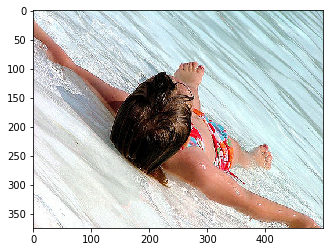

['a girl in a bikini is jumping into the water']


In [66]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
image_file_dir = './put-your-image-here/example.jpg'

# 展示图片
img = mpimg.imread(image_file_dir)
plt.imshow(img)

#用训练好的模型添加caption
caption = generate_caption_from_file(image_file_dir)
plt.show()

print(caption)